# Transformation Equations:  ComCam DP1 <--> DES DR2

_Meagan N. Porter, Douglas L. Tucker, Christina L. Adair_

_2025.9.26_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime
import re

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

from IPython.display import Markdown, display

import matplotlib.pyplot as plt

%matplotlib inline

## 2. Input Parameters

In [2]:
# ComCam-->DES DR2 (toComCam=False) or DES DR2-->ComCam (toComCam=True)...
toComCam = True
#toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    # If DES-->ComCam, then the mag and color to fit against are DES...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_ComCam':'g_des', 'r_ComCam':'r_des', 'i_ComCam':'i_des', 'z_ComCam':'z_des', 'y_ComCam':'Y_des'}
    # Color to fit against...
    color_name_1_dict = {'g_ComCam':'gi_des', 'r_ComCam':'gi_des', 'i_ComCam':'gi_des', 'z_ComCam':'iz_des', 'y_ComCam':'iz_des'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_ComCam':'$(g-i)_{des}$', 'r_ComCam':'$(g-i)_{des}$', 'i_ComCam':'$(g-i)_{des}$', 'z_ComCam':'$(i-z)_{des}$', 'y_ComCam':'$(i-z)_{des}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'g_ComCam':[-10.,2.3,10.], 
                           'r_ComCam':[-10.,2.0,10.], 
                           'i_ComCam':[-10.,1.8,10.],
                           'z_ComCam':[-10.,0.2,10.],
                           'y_ComCam':[-10.,0.2,10.]}

else:
    # List of DES bands on which to run the transform fit...
    bandList = ['g_des', 'r_des', 'i_des', 'z_des', 'Y_des']
    # If ComCam-->DES, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'g_des':'g_ComCam', 'r_des':'r_ComCam', 'i_des':'i_ComCam', 'z_des':'z_ComCam', 'Y_des':'y_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'g_des':'gi_ComCam', 'r_des':'gi_ComCam', 'i_des':'gi_ComCam', 'z_des':'iz_ComCam', 'Y_des':'iz_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'g_des':'$(g-i)_{ComCam}$', 'r_des':'$(g-i)_{ComCam}$', 'i_des':'$(g-i)_{ComCam}$', 'z_des':'$(i-z)_{ComCam}$', 'Y_des':'$(i-z)_{ComCam}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'g_des':[-10.,2.3,10.], 
                           'r_des':[-10.,2.0,10.], 
                           'i_des':[-10.,1.8,10.],
                           'z_des':[-10.,0.2,10.],
                           'Y_des':[-10.,0.2,10.]}


# Order of polynomial fits...
norder = 1

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# ComCam data
collection='LSSTComCam/DP1'
repo = 'dp1'
skymap = 'lsst_cells_v1'
instrument = 'LSSTComCam'

# URL of DES DR2 FGCM standard stars FITS table
des_url = "http://desdr-server.ncsa.illinois.edu/despublic/other_files/y6_standards/Y6A1_FGCM_V3_3_1_PSF_ALL_STARS.fits"

#use match file?
useMatchFile = True

# Name of the match file
matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cfds_comcam_match.csv'
#matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cdfs_comcam_match_W2025_10.csv'
#matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cdfs_comcam_match_dp1_new.csv'


# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.DESDR2_to_ComCam_ECDFS.fit'
else:
    qaFileBaseName = 'qaPlot.ComCam_to_DESDR2_ECDFS.fit'

# Write a Markdown-formatted summary table of the fits?
write_md_file = True
if write_md_file:
    # Auto-name the .md file based on qaFileBaseName
    md_filename = f"{qaFileBaseName}.qa_summary.md"

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }

## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Additional mask to ensure indices are valid
    valid_idx_mask = idx[mask] < len(df2)
    combined_mask = mask.copy()
    combined_mask[mask] = valid_idx_mask
    
    # Create a new dataframe with matches
    matches = df1[combined_mask].copy()
    matches['match_idx'] = idx[combined_mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[combined_mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        #matches[f'match_{col}'] = df2.loc[idx[mask], col].values
        # This is a safer way to to this, avoid out-of-bound indices:
        matches[f'match_{col}'] = df2.iloc[idx[combined_mask]][col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~combined_mask]

    return matches, unmatched

In [5]:
def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    if len(dmag) < 1000:
        plt.scatter(color1, dmag, alpha=0.75)
        #hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno_r')
    else:
        hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    if len(dmag) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    if len(res) < 100:
        plt.hist(res,bins=10)
    else:
        plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224)
    if len(res) < 1000:
        plt.scatter(color1, res, alpha=0.75)
        #hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno_r')
    else:
        hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    if len(res) >= 1000:
        cb = plt.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


In [6]:
# Kudos to Claude-3.5-Sonnet for improving on old outlier rejection code...

def poly_fit_with_sigma_clip(x, y, degree=1, sigma=3.0, maxiters=5):
    """
    Perform polynomial fit with iterative sigma clipping
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like 
        Dependent variable
    degree : int
        Degree of polynomial fit
    sigma : float
        Sigma clipping threshold
    maxiters : int
        Maximum number of sigma clipping iterations
        
    Returns:
    --------
    coeffs : array
        Polynomial coefficients
    mask : array
        Boolean mask indicating non-clipped points
    rms : float
        RMS of residuals
    """

    # Import relevant modules
    import numpy as np
    from astropy.stats import sigma_clip
    
    # Initial fit using all points
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.ones_like(x, dtype=bool)
    
    for _ in range(maxiters):
        print(len(x[mask]), len(y[mask]), len(mask))

        # Fit polynomial to non-masked points
        coeffs, cov = np.polyfit(x[mask], y[mask], degree, cov=True)
        
        # Calculate residuals
        yfit = np.polyval(coeffs, x)
        residuals = y - yfit
        
        # Update mask with sigma clipping
        new_mask = ~sigma_clip(residuals, sigma=sigma).mask
        
        # Check for convergence
        if np.array_equal(mask, new_mask):
            break
        
        mask = new_mask
    
    # Calculate final RMS
    final_residuals = y[mask] - np.polyval(coeffs, x[mask])
    rms = np.sqrt(np.mean(final_residuals**2))

    print(len(x[mask]), len(y[mask]), len(mask))

    # Calculate coefficient errors from diagonal of covariance matrix
    coeff_errors = np.sqrt(np.diag(cov))
        
    return coeffs, coeff_errors, x[mask], y[mask], final_residuals, rms

In [7]:
# Kudos to Copilot ChatGPT-5 for these functions for generating Markdown output 
#  of the fit equations...
# See:  https://copilot.microsoft.com/shares/Nopgin8hutEqEmjqJkteY

def latexify_label(label: str) -> str:
    """Strip $ and convert underscores to LaTeX subscripts."""
    label = label.strip('$')
    return re.sub(r'_(\w+)', r'_{\1}', label)

def latexify_name(name: str) -> str:
    """Convert underscores in names to LaTeX subscripts."""
    return re.sub(r'_(\w+)', r'_{\1}', name)

def make_eq_str(dmagName, p_branch, colorLabel_1, norder):
    """
    Build a LaTeX-formatted transformation equation for Markdown.
    Ensures all terms are inside a single $...$ block with proper signs.
    """
    label = latexify_label(colorLabel_1)           # e.g., (g-i)_{ComCam}
    dmagName_math = latexify_name(dmagName)        # e.g., U - u_{ComCam}

    terms = []
    power = norder
    for coeff in p_branch:
        if power == 0:
            # Constant term: no variable
            terms.append(f"{coeff:+.3f}")
        elif power == 1:
            # Linear term
            terms.append(f"{coeff:+.3f} {label}")
        else:
            terms.append(f"{coeff:+.3f} {label}^{power}")
            # Higher-order term
        power -= 1

    # Join all terms with spaces; signs are already included in coeff formatting
    eq_body = " ".join(terms)
    return f"${dmagName_math} = {eq_body}$"

def make_range_str(color_limits, colorLabel_1, ibranch):
    label = latexify_label(colorLabel_1)
    # Use LaTeX \leq for "less than or equal to"
    return (f"${color_limits[ibranch]:.1f} < {label} \\leq "
            f"{color_limits[ibranch+1]:.1f}$")

def make_output_filename(base, magName, magName_match, color_name_1, norder):
    return f"{base}.dmag_{magName}-{magName_match}.{color_name_1}.norder{norder}.qa1.png"


In [8]:
# Kudos to Copilot ChatGPT-5 for improving the plot text generation

def make_plot_text(dmagName, p_branch, colorLabel_1, norder,
                   color_limits, ibranch, stddev_branch):
    """
    Build a descriptive text string for plots, valid for any polynomial order.
    Example output:
    "g - r = -0.041 -0.302*(g-i)   [0.2 < (g-i) <= 2.5]   [rms: 0.022]"
    """
    terms = []
    power = norder
    for coeff in p_branch:
        if power == 0:
            # Constant term, but still include sign
            terms.append(f"{coeff:+.3f}")
        elif power == 1:
            terms.append(f"{coeff:+.3f}*{colorLabel_1}")
        else:
            terms.append(f"{coeff:+.3f}*{colorLabel_1}^{power}")
        power -= 1

    poly_str = " ".join(terms)

    lo = color_limits[ibranch]
    hi = color_limits[ibranch+1]
    range_str = f"[{lo:.1f} < {colorLabel_1} <= {hi:.1f}]"
    rms_str = f"[rms: {stddev_branch:.3f}]"

    return f"{dmagName} = {poly_str}  {range_str}  {rms_str}"

## X. Read in Matched Catalog

In [9]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


matchFile:  /home/d/dltucker/DATA/SP-1736/sciunit_photocalib/cfds_comcam_match.csv


In [10]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    tab

In [11]:
if useMatchFile:
    matches = tab.to_pandas()
    matches

## 4. Query ComCam Catalog

In [12]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler = Butler(repo, collections=collection)
    skybutler = Butler(repo, collections=collection, skymap=skymap)

In [13]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [14]:
# Download stars from the Extended Chandra Deep Field South (ECDFS)...
if not useMatchFile:
    comcam_stars_list = []

    for tractId in tract_list:

        if tract_dict[tractId] != 'ECDFS':
            continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                    collections=[collection],
                                    parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")

            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


In [15]:
if not useMatchFile:
    comcam_stars_all


In [16]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

## 5. Access DES DR2 FGCM Standard Stars Table

In [17]:
# Read DES DR2 FGCM Standard Stars Table
if not useMatchFile:
    tab = Table.read(des_url, format="fits")
    combined_df = tab.to_pandas()

In [18]:
if not useMatchFile:
    display(combined_df)

In [19]:
#combined_df.to_csv("ECFDS_desDR2_20250627.csv",index=False)

## 6. Match ComCam and DES DR2 FGCM standard stars

In [20]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, combined_df, 
                                              'coord_ra', 'coord_dec', 
                                              'raMean', 'decMean')

In [21]:
if not useMatchFile:
    matches

In [22]:
if not useMatchFile:
    matches.to_csv(matchFile,index=False)

In [23]:
#if not useMatchFile:
#    display(unmatched)

##  7. Add ABmag Columns to Matched Catalog Data Frame

In [24]:
# Copy matches to df...
df = matches.copy()

In [25]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = df[flux_col] > 0

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10



In [26]:
df

,coord_ra,coord_dec,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,g_psfMag,g_psfMagErr,r_psfMag,r_psfMagErr,i_psfMag,i_psfMagErr,z_psfMag,z_psfMagErr,y_psfMag,y_psfMagErr
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,22.114746,0.010889,21.646814,0.013418,20.969176,0.008158,20.750952,0.019414,20.706108,0.081158
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,16.935766,0.000363,15.791276,0.000209,15.411141,0.000369,15.293736,0.000468,14.970000,0.001175
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,19.065767,0.000986,17.741582,0.000454,16.712557,0.000509,16.264982,0.000478,16.043396,0.002079
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,22.140187,0.008162,20.892871,0.003243,19.502652,0.002257,18.892137,0.002240,18.575687,0.012577
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,19.770356,0.002085,18.464186,0.001655,17.654335,0.001441,17.298915,0.001330,17.105566,0.004090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,52.697296,-27.618446,true,30319.046999,589.635680,31472.320312,857.952332,1.0,false,294819.308343,...,17.726110,0.000639,16.614531,0.000715,16.139440,0.000397,15.930661,0.000653,15.821167,0.001872
1727,52.692036,-27.594183,true,1037.431574,476.144663,1673.366821,806.086548,NaN,false,3449.893664,...,22.555486,0.019037,21.299258,0.010655,20.121055,0.004875,19.627588,0.006636,19.401907,0.025443
1728,52.708140,-27.587144,true,20808.893176,541.832540,24280.568359,842.446716,1.0,false,112181.657067,...,18.775195,0.001543,18.090742,0.001423,17.803379,0.000981,17.684033,0.002961,17.602264,0.005833
1729,52.708179,-27.563956,true,4824.976859,480.571450,5251.936035,790.970093,1.0,false,49550.772106,...,19.662374,0.003245,18.660878,0.001964,18.250025,0.001244,18.111158,0.003959,17.965853,0.007577


In [27]:
# Remove the prefix "match_" from all column names
df.columns = df.columns.str.replace(r"^match_", "", regex=True)

# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'RA':'RA_des',
                   'DEC':'DEC_des',
                   'MAG_STD_G':'g_des',
                   'MAG_STD_R':'r_des',
                   'MAG_STD_I':'i_des',
                   'MAG_STD_Z':'z_des',
                   'MAG_STD_Y':'Y_des',
                   'MAGERR_STD_G':'g_err_des',
                   'MAGERR_STD_R':'r_err_des',
                   'MAGERR_STD_I':'i_err_des',
                   'MAGERR_STD_Z':'z_err_des',
                   'MAGERR_STD_Y':'Y_err_des'
                  },inplace=True)

df.head(5)

,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,g_ComCam,g_err_ComCam,r_ComCam,r_err_ComCam,i_ComCam,i_err_ComCam,z_ComCam,z_err_ComCam,y_ComCam,y_err_ComCam
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,22.114746,0.010889,21.646814,0.013418,20.969176,0.008158,20.750952,0.019414,20.706108,0.081158
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,16.935766,0.000363,15.791276,0.000209,15.411141,0.000369,15.293736,0.000468,14.970000,0.001175
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,19.065767,0.000986,17.741582,0.000454,16.712557,0.000509,16.264982,0.000478,16.043396,0.002079
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,22.140187,0.008162,20.892871,0.003243,19.502652,0.002257,18.892137,0.002240,18.575687,0.012577
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,19.770356,0.002085,18.464186,0.001655,17.654335,0.001441,17.298915,0.001330,17.105566,0.004090


In [28]:
df.columns

Index(['RA_ComCam', 'DEC_ComCam', 'detect_isPrimary', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'FGCM_ID',
       'RA_des', 'DEC_des', 'FLAG', 'g_des', 'r_des', 'i_des', 'z_des',
       'Y_des', 'g_err_des', 'r_err_des', 'i_err_des', 'z_err_des',
       'Y_err_des', 'NGOOD_G', 'NGOOD_R', 'NGOOD_I', 'NGOOD_Z', 'NGOOD_Y',
       'Separation', 'u_psfMag', 'u_psfMagErr', 'g_ComCam', 'g_err_ComCam',
     

## 8. Add Color Columns to Matched Catalog Data Frame

In [29]:
# Add color columns...
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

In [30]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

In [31]:
df

,RA_ComCam,DEC_ComCam,detect_isPrimary,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,g_psfFlux,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,gr_des,ri_des,iz_des,zY_des,gi_des,dmag
0,53.781187,-28.185720,true,1703.442901,323.855118,19.500370,616.454041,NaN,false,5177.278944,...,0.677638,0.218224,0.044844,1.145570,0.456751,0.476538,0.211168,-77.959032,0.933289,-9999.0
1,53.733393,-28.258385,true,60838.558049,235.315937,61629.753906,321.616547,0.0,false,610510.896363,...,0.380135,0.117405,0.323736,1.524626,1.222000,0.449580,0.221703,0.046042,1.671580,-9999.0
2,53.729334,-28.257718,true,7996.038835,156.261632,8031.438477,286.487122,0.0,false,85840.655645,...,1.029025,0.447575,0.221586,2.353211,1.460573,1.011080,0.430197,0.104381,2.471653,-9999.0
3,53.727539,-28.254317,true,706.064935,140.356212,1338.280151,273.060425,NaN,false,5057.377201,...,1.390219,0.610516,0.316450,2.637534,1.413175,1.379688,0.591211,0.150719,2.792863,-9999.0
4,53.759904,-28.263316,true,4067.139078,195.514315,4030.758789,368.332703,0.0,false,44859.808983,...,0.809851,0.355420,0.193350,2.116021,1.432077,0.786019,0.351070,0.085464,2.218096,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,52.697296,-27.618446,true,30319.046999,589.635680,31472.320312,857.952332,1.0,false,294819.308343,...,0.475091,0.208780,0.109493,1.586670,1.186912,0.433548,0.216721,0.045899,1.620460,-9999.0
1727,52.692036,-27.594183,true,1037.431574,476.144663,1673.366821,806.086548,NaN,false,3449.893664,...,1.178203,0.493467,0.225682,2.434431,1.411276,1.161955,0.483328,0.110292,2.573231,-9999.0
1728,52.708140,-27.587144,true,20808.893176,541.832540,24280.568359,842.446716,1.0,false,112181.657067,...,0.287363,0.119346,0.081769,0.971816,0.736573,0.257606,0.137482,0.015814,0.994179,-9999.0
1729,52.708179,-27.563956,true,4824.976859,480.571450,5251.936035,790.970093,1.0,false,49550.772106,...,0.410854,0.138866,0.145305,1.412349,1.071093,0.375330,0.191507,0.041371,1.446423,-9999.0


(15.0, 30.0)

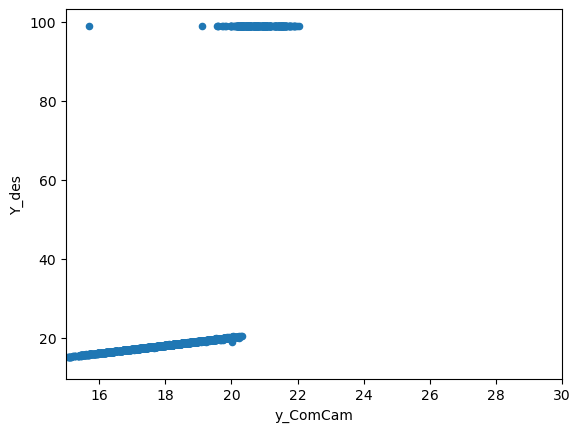

In [32]:
df.plot('y_ComCam', 'Y_des', kind='scatter')
plt.xlim([15,30.])

## 9. Create Initial Mask

In [33]:
mask1 = df["g_ComCam"] > 0.
mask2 = df["r_ComCam"] > 0.
mask3 = df["i_ComCam"] > 0.
mask4 = df["z_ComCam"] > 0.
mask5 = df["y_ComCam"] > 0.
mask6 = df["g_err_ComCam"] <= 0.02
mask7 = df["r_err_ComCam"] <= 0.02
mask8 = df["i_err_ComCam"] <= 0.02
mask9 = df["z_err_ComCam"] <= 0.02
mask10 = df["y_err_ComCam"] <= 0.04
mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask1 = (df["g_des"] > 0.) & (df["g_des"] < 30.)
mask2 = (df["r_des"] > 0.) & (df["r_des"] < 30.)
mask3 = (df["i_des"] > 0.) & (df["i_des"] < 30.)
mask4 = (df["z_des"] > 0.) & (df["z_des"] < 30.)
mask5 = (df["Y_des"] > 0.) & (df["Y_des"] < 30.)
mask6 = df["g_err_des"] <= 0.02
mask7 = df["r_err_des"] <= 0.02
mask8 = df["i_err_des"] <= 0.02
mask9 = df["z_err_des"] <= 0.02
mask10 = df["Y_err_des"] <= 0.04

mask_des = mask1 & mask2 & mask3  & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10

mask = mask_ComCam & mask_des


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [34]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## 11. Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # 
g_ComCam
# # # # # # # # # # # # # # # # # # # # 

g_ComCam [-10.0, 2.3, 10.0] 2
g_ComCam [-0.7, 2.3, 4.0] 2
*********************************
0 -0.7 2.3
*********************************
mask_branch length (before): 1376
dmag_branch length: 825
color1_branch length: 825
825 825 825
788 788 825
787 787 825
787 787 825
mask_branch length (after): 1376
p_1 = -0.000777 ± 0.000425
p_0 = 0.005177 ± 0.000611

g_ComCam - g_des = 0.005 + -0.001*$(g-i)_{des}$ [-0.7 < $(g-i)_{des}$ <= 2.3] [rms: 0.008]
g_ComCam - g_des = -0.001*$(g-i)_{des}$ +0.005  [-0.7 < $(g-i)_{des}$ <= 2.3]  [rms: 0.008]

g_ComCam - g_des = -0.001*$(g-i)_{des}$ +0.005  [-0.7 < $(g-i)_{des}$ <= 2.3]  [rms: 0.008]
*********************************
1 2.3 4.0
*********************************
mask_branch length (before): 1376
dmag_branch length: 551
color1_branch length: 551
551 551 551
533 533 551
533 533 551
mask_branch length (after): 1376
p_1 = 0.015579 ± 0.002934
p_0 = -0.026225 

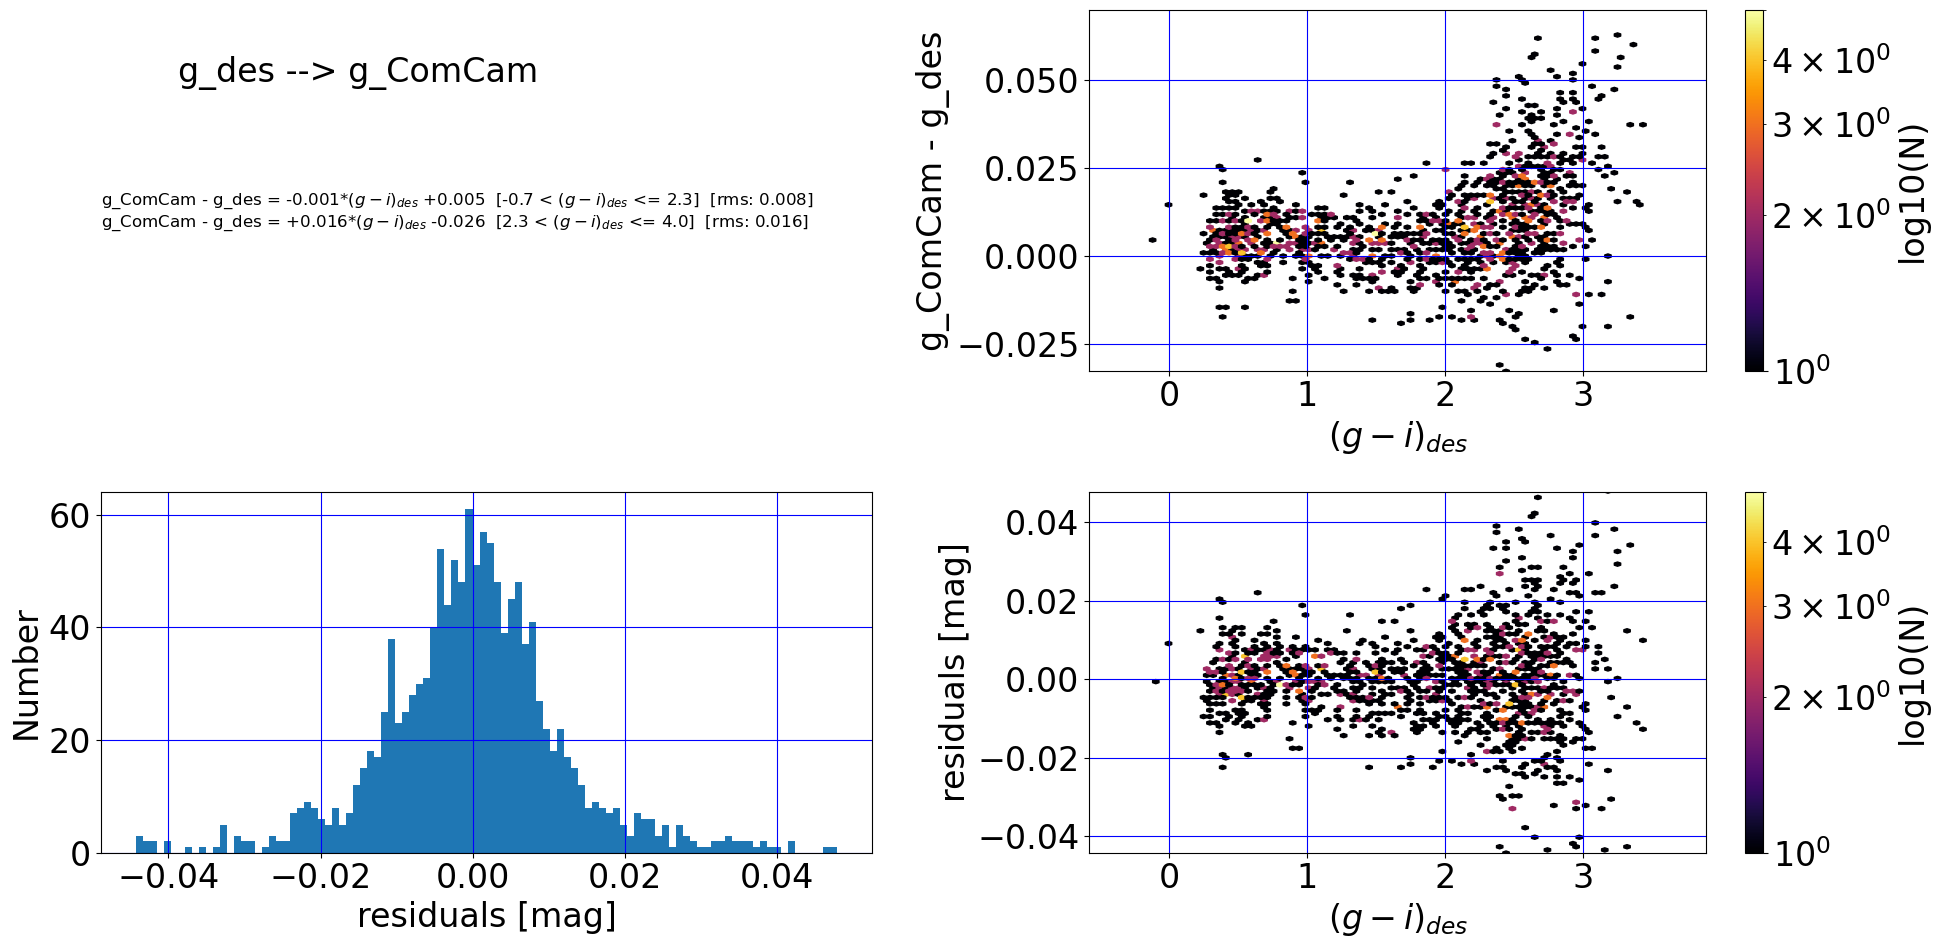

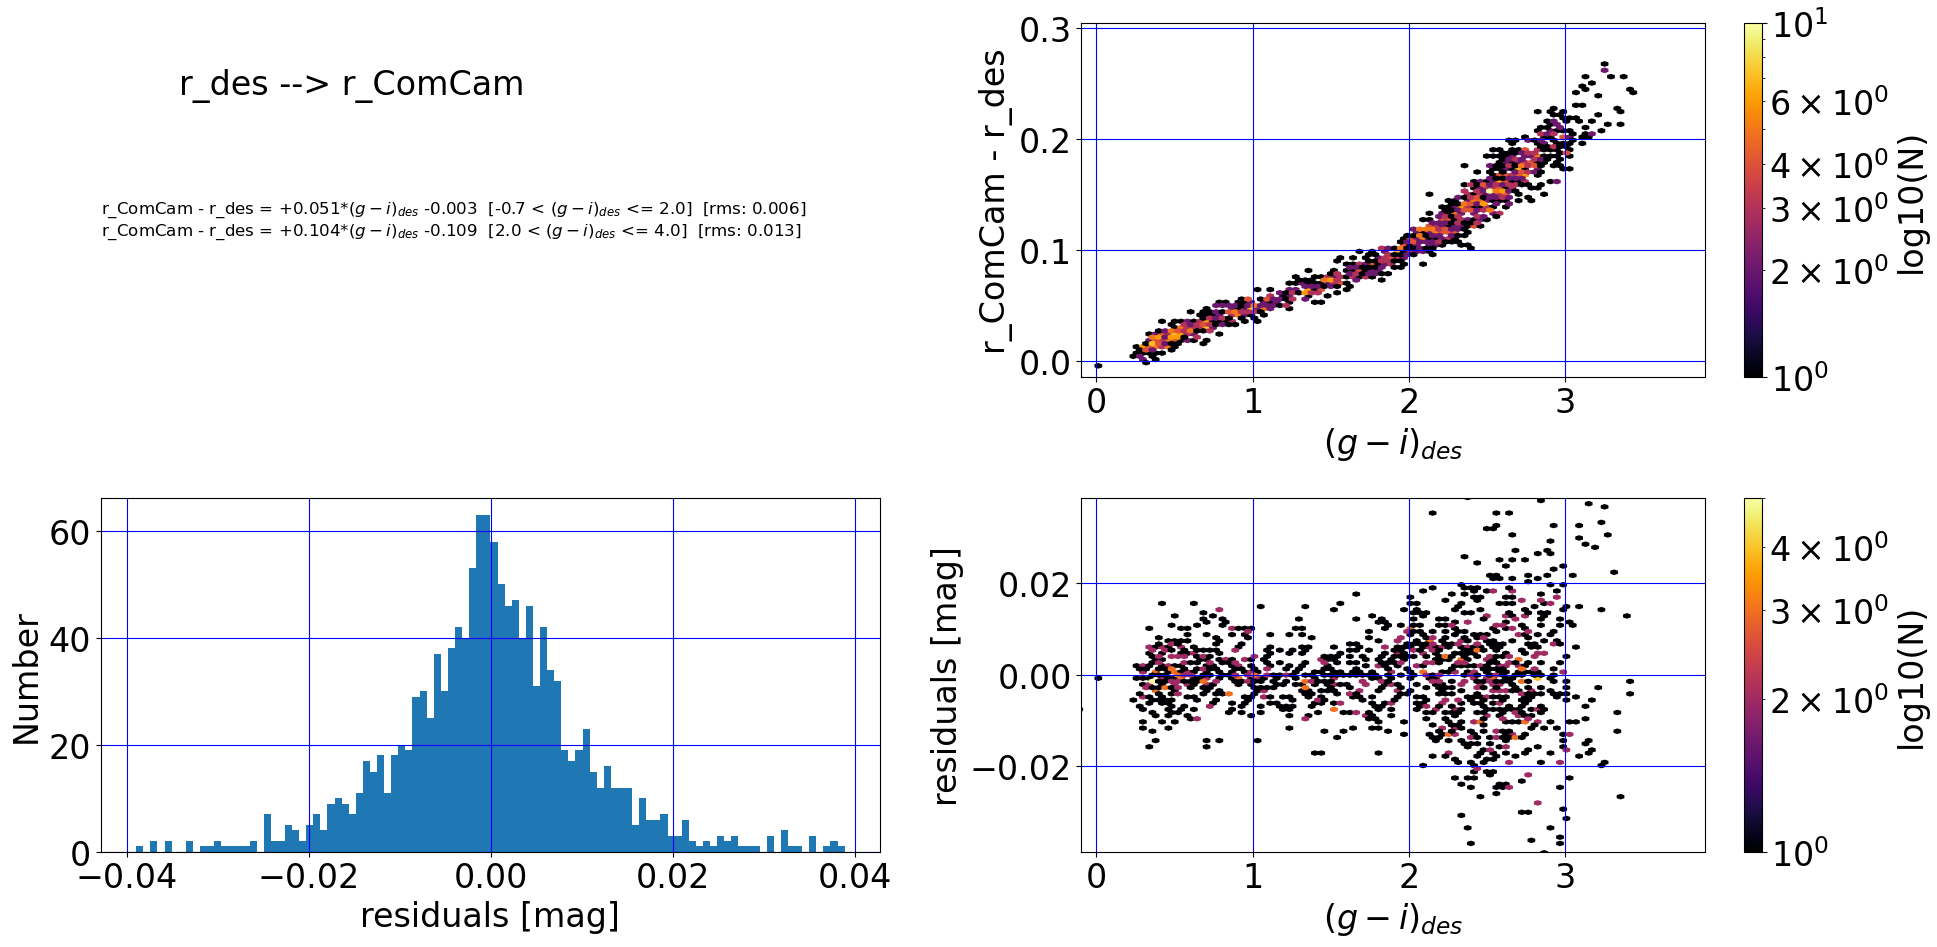

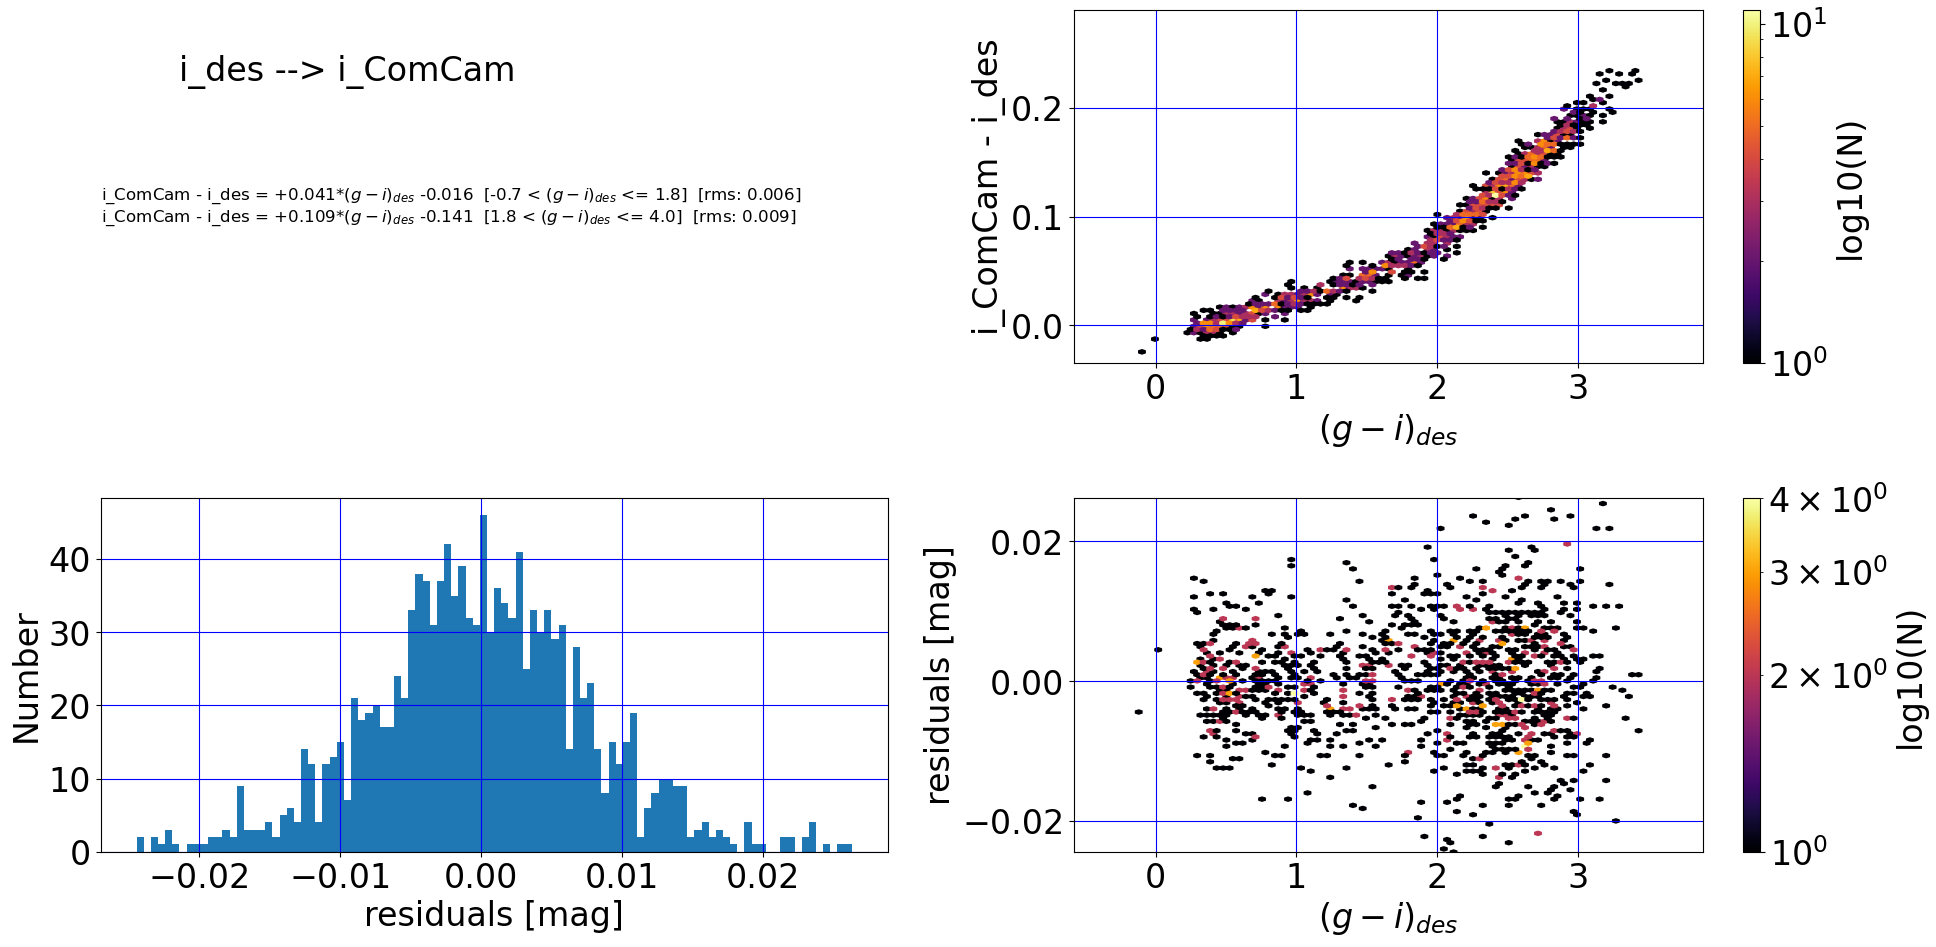

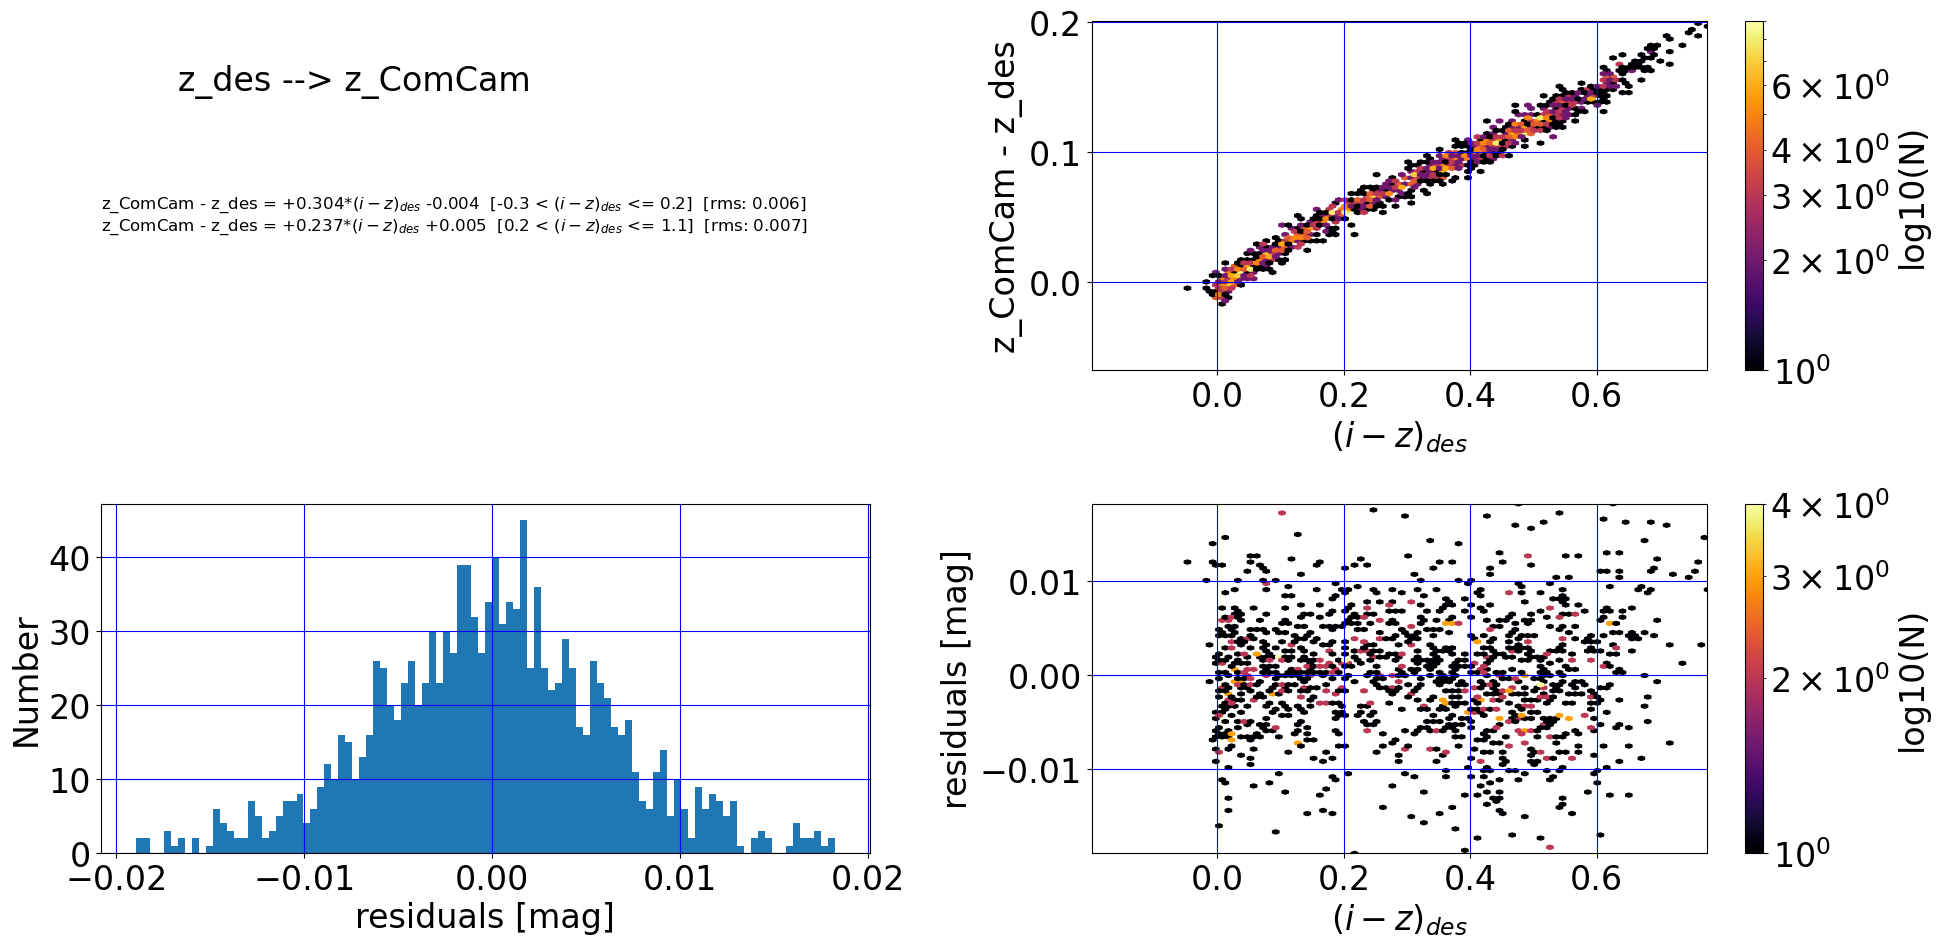

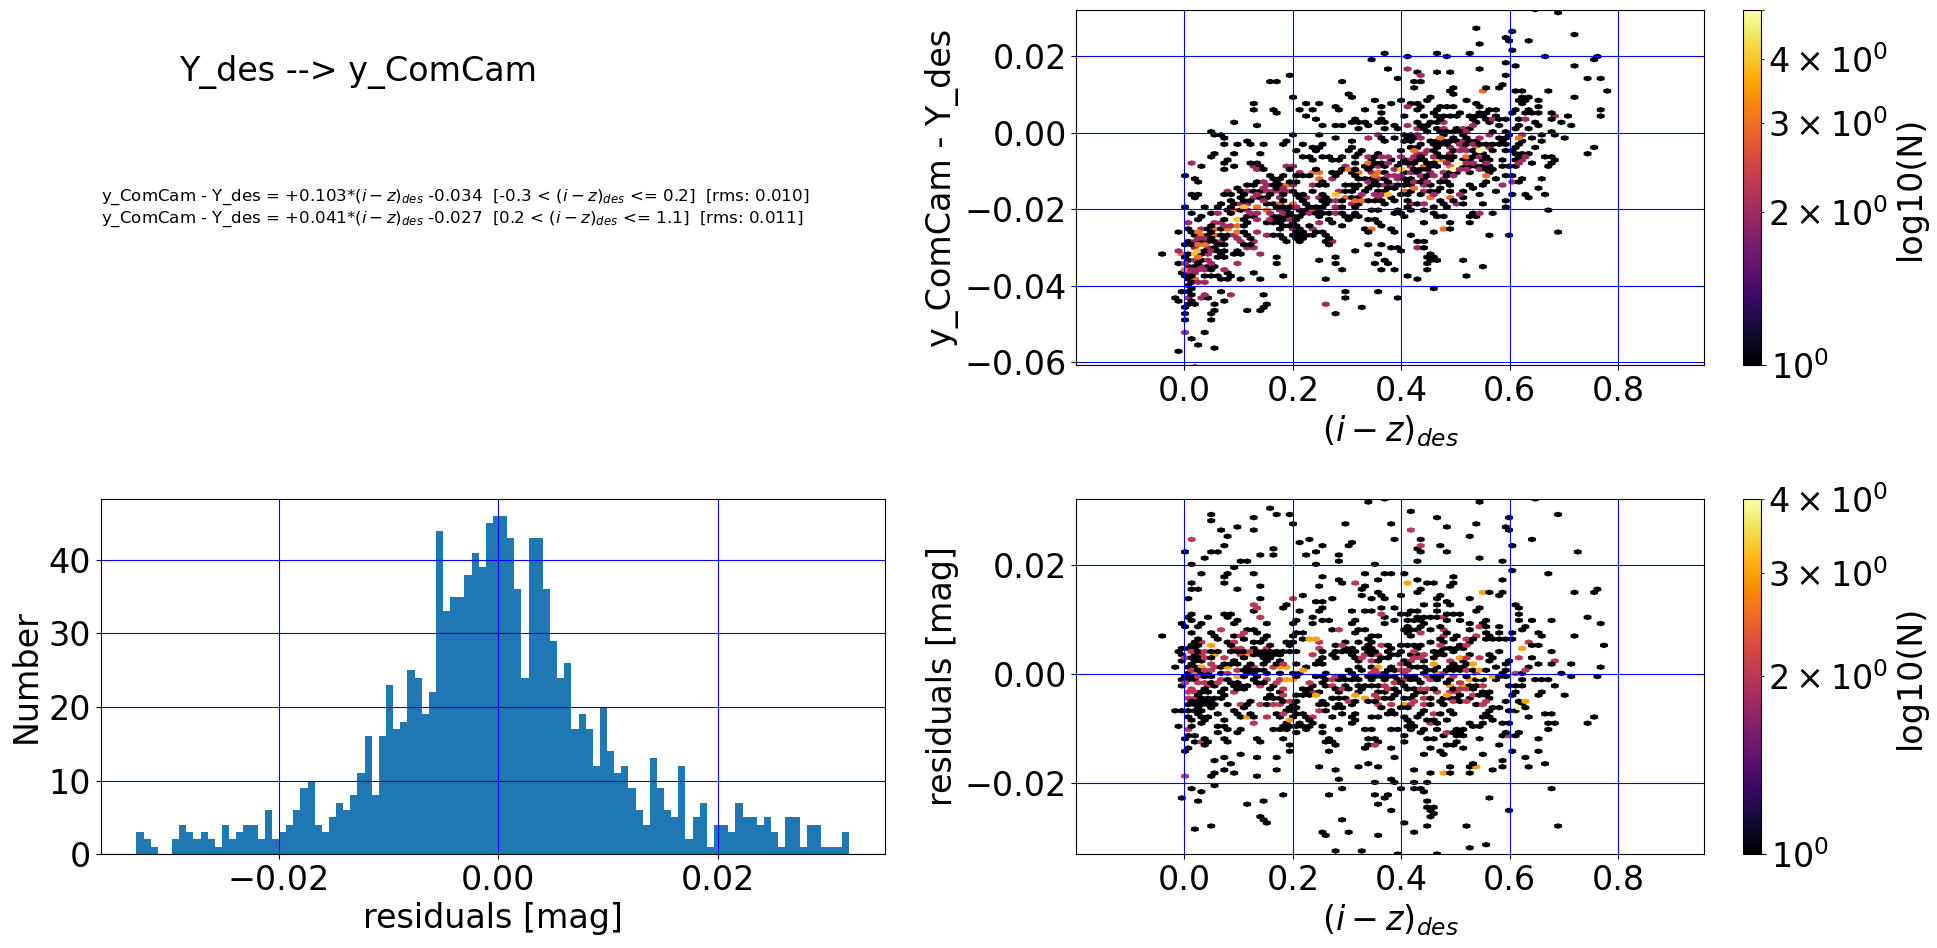

In [35]:
# --- Accumulator for ALL bands ---
qa_rows_all = []

# --- Main loop ---
for band in bandList:

    print("\n\n\n" + "# " * 20)
    print(band)
    print("# " * 20 + "\n")

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    # Create title/names for use in QA plots...
    title = f"{magName_match} --> {magName}"
    dmagName = f"{magName} - {magName_match}"

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:, 'dmag'] = df.loc[:, magName] - df.loc[:, magName_match]

    # Update mask...
    mask1 = (abs(df['dmag']) <= 10.)
    mask2 = ((df[color_name_1] > -3.) & (df[color_name_1] < 6.0))
    mask = mask & mask1 & mask2
    df = df[mask]

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0:
        print(band, color_limits_1_dict[band], nbranches)

    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    dftmp = df
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0:
        print(band, color_limits_1_dict[band], nbranches)

    # Iterate, with sigma-clipping...
    color1_list = []
    dmag_list = []
    res_list = []
    mask_list = []
    plot1Text = ''

    for ibranch in range(nbranches):

        print('*********************************')
        print(ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1])
        print('*********************************')

        mask_branch = ((df[color_name_1] > color_limits_1_dict[band][ibranch]) &
                       (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]))
        df_branch = df[mask_branch].copy()

        # ... and extract dmag's and color1's for this branch...
        dmag_branch = df_branch.loc[:, 'dmag']
        color1_branch = df_branch.loc[:, color_name_1]

        # If there are no valid colors on this branch, continue to next branch...
        if len(color1_branch) < 1:
            continue

        # Perform fit for each disjoint branch...
        print("mask_branch length (before):", len(mask_branch))
        print("dmag_branch length:", len(dmag_branch))
        print("color1_branch length:", len(color1_branch))

        p_branch, perr_branch, color1_branch, dmag_branch, res_branch, stddev_branch = \
            poly_fit_with_sigma_clip(color1_branch, dmag_branch, degree=norder)

        print("mask_branch length (after):", len(mask_branch))

        # Print coefficients and estimated statistical errors in the coefficients
        for i, (p, perr) in enumerate(zip(p_branch, perr_branch)):
            print(f'p_{len(p_branch)-i-1} = {p:.6f} ± {perr:.6f}')

        # --- Build Markdown table row and add to global list ---
        eq_str = make_eq_str(dmagName, p_branch, colorLabel_1, norder)
        range_str = make_range_str(color_limits_1_dict[band], colorLabel_1, ibranch)
        outputFileName = make_output_filename(
            qaFileBaseName, magName, magName_match, color_name_1, norder
        )
        link_str = f"[link](_static/plots/{outputFileName})"
        title_math = latexify_name(title)
        title_math = title_math.replace("-->", "\\to")
        qa_rows_all.append({
            "Conversion": f"${title_math}$",
            "Transformation Equation": eq_str,
            "RMS": round(stddev_branch, 3),
            "Applicable Color Range": range_str,
            "QA Plot": link_str
        })

        # Keep original plot1Text for QA plots
        if norder == 1:
            plot1Text1 = f"{dmagName} = {p_branch[1]:.3f} + {p_branch[0]:.3f}*{colorLabel_1} " \
                         f"[{color_limits_1_dict[band][ibranch]:.1f} < {colorLabel_1} <= {color_limits_1_dict[band][ibranch+1]:.1f}] " \
                         f"[rms: {stddev_branch:.3f}]"
        elif norder == 2:
            plot1Text1 = f"{dmagName} = {p_branch[2]:.3f} + {p_branch[1]:.3f}*{colorLabel_1} " \
                         f"+ {p_branch[0]:.3f}*{colorLabel_1}^2  " \
                         f"[{color_limits_1_dict[band][ibranch]:.1f} < {colorLabel_1} <= {color_limits_1_dict[band][ibranch+1]:.1f}] " \
                         f"[rms: {stddev_branch:.3f}]"
        else:
            plot1Text1 = ''

        plot1Text1_old = f"{plot1Text}\n{plot1Text1}"
        print(plot1Text1_old)

        plot1Text1 = make_plot_text(
            dmagName, p_branch, colorLabel_1, norder,
            color_limits_1_dict[band], ibranch, stddev_branch
        )
        plot1Text = f"{plot1Text}\n{plot1Text1}"
        print(plot1Text1)
        print(plot1Text)


        # Append branch df and mask to the df_list and mask_list lists, respectively...
        #df_list.append(df_branch.copy())
        #mask_list.append(mask_branch.copy())
        color1_list.append(color1_branch.copy())
        dmag_list.append(dmag_branch.copy())
        res_list.append(res_branch.copy())
        mask_list.append(mask_branch.copy())

    # Concatenate the color1, dmag, res, and mask lists for all the branches...
    color1 = pd.Series(np.concatenate(color1_list))
    dmag = pd.Series(np.concatenate(dmag_list))
    res = pd.Series(np.concatenate(res_list))
    mask = pd.Series(np.concatenate(mask_list))

    # Calculate the standard deviation for the full piecewise fit...
    stddev = res.std()

    # Output best fits to screen...
    if verbose > 0:
        print("")
        print(title)
        print(plot1Text)
        print("")

    # Create QA plots...
    outputFileName = make_output_filename(
        qaFileBaseName, magName, magName_match, color_name_1, norder
    )
    status = transform1ColorQAPlots1a(
        dmag, color1, res, norder, title, plot1Text,
        dmagName, colorLabel_1, stddev, outputFileName
    )

# --- After ALL bands processed: display one big table ---
if qa_rows_all:
    qa_df_all = pd.DataFrame(qa_rows_all)
    # Generate Markdown string (older Pandas: escape removal trick)
    md_table_str = qa_df_all.to_markdown(index=False)
    md_table_str = md_table_str.replace(r'\_', '_')
    print(md_table_str)  # raw Markdown table source

    if write_md_file:
        with open(md_filename, "w") as f:
            f.write(md_table_str)
        print(f"\nMarkdown table written to: {md_filename}")



In [36]:
raise StopExecution

## 12.  Sandbox